In [94]:
import numpy as np
import pickle
import skimage.transform
import scipy
import numpy as np
import theano
import theano.tensor as T
from theano import config
import matplotlib.pyplot as plt
%matplotlib inline
floatX=theano.config.floatX

In [95]:
from nn import ConvLayer
from theano.tensor.signal import pool
IMAGE_W = 64
class vgg19(object):
    def __init__(self, input, width_1):
        batch_size =1 
#         self.input=input.reshape((batch_size,3,width_1,width_1))
        self.input = input
        rng=np.random.RandomState(11)
        self.layers={}
        
        self.conv1_1 = ConvLayer(rng,
            input=self.input,
            image_shape=(batch_size, 3, width_1, width_1),
            filter_shape=(64, 3, 3, 3),
            border_mode=1
        )
        self.conv1_2 = ConvLayer(
            rng,
            input=self.conv1_1.output,
            image_shape=(batch_size, 64, width_1, width_1),
            filter_shape=(64, 64, 3, 3),
            border_mode=1
        )
        self.pool1 = pool.pool_2d(
            input=self.conv1_2.output,
            ds=(2,2),mode='average_exc_pad'
        )
        width_2 = width_1/2


        self.conv2_1 = ConvLayer(
            rng,
            input=self.pool1,
            image_shape=(batch_size, 64, width_2, width_2),
            filter_shape=(128, 64, 3, 3),
            border_mode=1
        )
        self.conv2_2  = ConvLayer(
            rng,
            input=self.conv2_1.output,
            image_shape=(batch_size, 128, width_2, width_2),
            filter_shape=(128, 128, 3, 3),
            border_mode=1
        )
        self.pool2 = pool.pool_2d(
                input=self.conv2_2.output,
                ds=(2,2),mode='average_exc_pad'
        )    
        width_3 = width_2/2
        
        self.conv3_1 = ConvLayer(
            rng,
            input=self.pool2,
            image_shape=(batch_size, 128, width_3, width_3),
            filter_shape=(256, 128, 3, 3),
            border_mode=1
        )
        
        self.conv3_2 = ConvLayer(
            rng,
            input=self.conv3_1.output,
            image_shape=(batch_size, 256, width_3, width_3),
            filter_shape=(256, 256, 3, 3),
            border_mode=1
        )
        self.conv3_3 = ConvLayer(
            rng,
            input=self.conv3_2.output,
            image_shape=(batch_size, 256, width_3, width_3),
            filter_shape=(256, 256, 3, 3),
            border_mode=1
        )

        self.conv3_4 = ConvLayer(
            rng,
            input=self.conv3_3.output,
            image_shape=(batch_size, 256, width_3, width_3),
            filter_shape=(256, 256, 3, 3),
            border_mode=1
        )
        self.pool3 = pool.pool_2d(
                input=self.conv3_4.output,
                ds=(2,2),mode='average_exc_pad'
        ) 
        width_4 = width_3/2
        self.conv4_1 = ConvLayer(
            rng,
            input=self.pool3,
            image_shape=(batch_size, 256, width_4, width_4),
            filter_shape=(512, 256, 3, 3),
            border_mode=1
        )
        self.conv4_2 = ConvLayer(
            rng,
            input=self.conv4_1.output,
            image_shape=(batch_size, 512, width_4, width_4),
            filter_shape=(512, 512, 3, 3),
            border_mode=1
        )
        self.conv4_3 = ConvLayer(
            rng,
            input=self.conv4_2.output,
            image_shape=(batch_size, 512, width_4, width_4),
            filter_shape=(512, 512, 3, 3),
            border_mode=1
        )

        self.conv4_4 = ConvLayer(
            rng,
            input=self.conv4_3.output,
            image_shape=(batch_size, 512, width_4, width_4),
            filter_shape=(512, 512, 3, 3),
            border_mode=1
        )
        self.pool4 = pool.pool_2d(
                input=self.conv4_4.output,
                ds=(2,2),mode='average_exc_pad'
        ) 
        width_5 = width_4/2
        self.conv5_1 = ConvLayer(
            rng,
            input=self.pool4,
            image_shape=(batch_size, 512, width_5, width_5),
            filter_shape=(512, 512, 3, 3),
            border_mode=1
        )
        self.conv5_2 = ConvLayer(
            rng,
            input=self.conv5_1.output,
            image_shape=(batch_size, 512, width_5, width_5),
            filter_shape=(512, 512, 3, 3),
            border_mode=1
        )
        self.conv5_3 = ConvLayer(
            rng,
            input=self.conv5_2.output,
            image_shape=(batch_size, 512, width_5, width_5),
            filter_shape=(512, 512, 3, 3),
            border_mode=1
        )

        self.conv5_4 = ConvLayer(
            rng,
            input=self.conv5_3.output,
            image_shape=(batch_size, 512, width_5, width_5),
            filter_shape=(512, 512, 3, 3),
            border_mode=1
        )
        self.pool5 = pool.pool_2d(
                input=self.conv5_4.output,
                ds=(2,2),mode='average_exc_pad'
        )
        self.output=self.pool5
        self.layers['conv1_1']=self.conv1_1
        self.layers['conv1_2']=self.conv1_2
        self.layers['conv2_1']=self.conv2_1
        self.layers['conv2_2']=self.conv2_2
        self.layers['conv3_1']=self.conv3_1
        self.layers['conv3_2']=self.conv3_2
        self.layers['conv3_3']=self.conv3_3
        self.layers['conv3_4']=self.conv3_4
        self.layers['conv4_1']=self.conv4_1
        self.layers['conv4_2']=self.conv4_2
        self.layers['conv4_3']=self.conv4_3
        self.layers['conv4_4']=self.conv4_4
        self.layers['conv5_1']=self.conv5_1
        self.layers['conv5_2']=self.conv5_2
        self.layers['conv5_3']=self.conv5_3
        self.layers['conv5_4']=self.conv5_4

    def set_params(self,values):
        i=0
        for name_key in self.layers.keys():
            self.layers[name_key].set_param(values[i],values[i+1])
            i=i+2

In [96]:
#!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg19_normalized.pkl
# !pip install pillow
# !pip install scikit-image --upgrade

In [97]:
values = pickle.load(open('vgg19_normalized.pkl'))['param values']

In [98]:

photo = plt.imread('../../data/Tuebingen_Neckarfront.jpg')


In [99]:
#!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg19_normalized.pkl


In [100]:
X = T.tensor4('X')
net = vgg19(X, IMAGE_W)
net.set_params(values) 

/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/ipykernel/__main__.py:27: UserWarning: pool_2d() will have the parameter ignore_border default value changed to True (currently False). To have consistent behavior with all Theano version, explicitly add the parameter ignore_border=True. On the GPU, using ignore_border=True is needed to use cuDNN. When using ignore_border=False and not using cuDNN, the only GPU combination supported is when `ds == st and padding == (0, 0) and mode == 'max'`. Otherwise, the convolution will be executed on CPU.
/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/ipykernel/__main__.py:48: UserWarning: pool_2d() will have the parameter ignore_border default value changed to True (currently False). To have consistent behavior with all Theano version, explicitly add the parameter ignore_border=True. On the GPU, using ignore_border=True is needed to use cuDNN. When using ignore_border=False and not using cuDNN, the only GPU combinatio

In [101]:
MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))

def prep_image(im):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (IMAGE_W, w*IMAGE_W/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*IMAGE_W/w, IMAGE_W), preserve_range=True)

    # Central crop
    h, w, _ = im.shape
    im = im[h//2-IMAGE_W//2:h//2+IMAGE_W//2, w//2-IMAGE_W//2:w//2+IMAGE_W//2]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert RGB to BGR
    im = im[::-1, :, :]

    im = im - MEAN_VALUES
    return rawim, np.asarray(
                im[np.newaxis],
                dtype=theano.config.floatX
            )

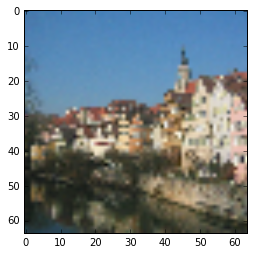

In [102]:
photo = plt.imread('../../data/Tuebingen_Neckarfront.jpg')
rawim, photo = prep_image(photo)
plt.imshow(rawim)

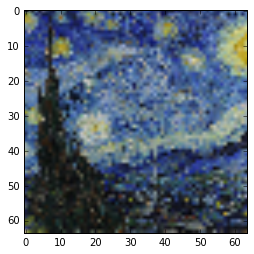

In [103]:
art = plt.imread('../../data/1920px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')
rawim, art = prep_image(art)
plt.imshow(rawim)

In [104]:
def gram_matrix(x):
    x = x.flatten(ndim=3)
    g = T.tensordot(x, x, axes=([2], [2]))
    return g


def content_loss(P, X, layer):
    p = P[layer]
    x = X[layer]
    
    loss = 1./2 * ((x - p)**2).sum()
    return loss


def style_loss(A, X, layer):
    a = A[layer]
    x = X[layer]
    
    A = gram_matrix(a)
    G = gram_matrix(x)
    
    N = a.shape[1]
    M = a.shape[2] * a.shape[3]
    
    loss = 1./(4 * N**2 * M**2) * ((G - A)**2).sum()
    return loss

def total_variation_loss(x):
    return (((x[:,:,:-1,:-1] - x[:,:,1:,:-1])**2 + (x[:,:,:-1,:-1] - x[:,:,:-1,1:])**2)**1.25).sum()

In [105]:
layers = ['conv4_2', 'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
layers = {k: net.layers[k] for k in layers}

In [106]:
# Precompute layer activations for photo and artwork
# input_im_theano = T.tensor4()

outputs =[layer_i.output for layer_i in layers.values()]

photo_features = {k: theano.shared(output.eval({X: photo}))
                  for k, output in zip(layers.keys(), outputs)}
art_features = {k: theano.shared(output.eval({X: art}))
                for k, output in zip(layers.keys(), outputs)}

In [107]:
photo_features["conv1_1"].eval()[0][1]

CudaNdarray([[  0.           0.           0.         ...,   0.           0.           0.        ]
 [  7.49349117  17.91454887  25.74412918 ...,  24.32926369  20.54106522
   10.51753616]
 [  1.93973768  19.16231346  20.30208206 ...,  25.76493835  24.06402206
    9.33467865]
 ..., 
 [ 34.93621445  10.59252739   7.7801609  ...,   0.           0.           0.        ]
 [ 22.17255783  11.3030777   10.04133224 ...,   0.          21.94858551
   29.82383156]
 [ 40.1102829   40.26165009  36.0308876  ...,  25.29415131  28.05487061
   28.3433876 ]])

In [108]:
    
# Get expressions for layer activations for generated image

gen_features = [layer_i.output for layer_i in layers.values()]

images=np.asarray(
                np.random.uniform(-128, 128, (1, 3, IMAGE_W, IMAGE_W)),
                dtype=theano.config.floatX
            )
gen_features = {k: theano.shared(output.eval({X: images}))
                for k, output in zip(layers.keys(), outputs)}

In [109]:
# Define loss function
losses = []

# content loss
losses.append(0.001 * content_loss(photo_features, gen_features, 'conv4_2'))

# style loss
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv1_1'))
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv2_1'))
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv3_1'))
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv4_1'))
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv5_1'))

# total variation penalty
losses.append(0.1e-7 * total_variation_loss(generated_image))

total_loss = sum(losses)

In [110]:
grad = T.grad(total_loss, generated_image)


In [111]:
# Theano functions to evaluate loss and gradient
f_loss = theano.function([], total_loss)
f_grad = theano.function([], grad)

# Helper functions to interface with scipy.optimize
def eval_loss(x0):
    x0 = x0.reshape((1, 3, IMAGE_W, IMAGE_W))
    generated_image.set_value(x0)
    return f_loss().astype('float64')

def eval_grad(x0):
    x0 = x0.reshape((1, 3, IMAGE_W, IMAGE_W))
    generated_image.set_value(x0)
    return np.array(f_grad()).flatten().astype('float64')

In [112]:
generated_image.set_value(np.random.uniform(-128, 128, (1, 3, IMAGE_W, IMAGE_W)))

x0 = generated_image.get_value().astype('float64')
xs = []
xs.append(x0)

# Optimize, saving the result periodically
for i in range(8):
    print(i)
    scipy.optimize.fmin_l_bfgs_b(eval_loss, x0.flatten(), fprime=eval_grad, maxfun=40)
    x0 = generated_image.get_value().astype('float64')
    xs.append(x0)

0
1
2
3
4
5
6
7


In [113]:
def deprocess(x):
    x = np.copy(x[0])
    x += MEAN_VALUES

    x = x[::-1]
    x = np.swapaxes(np.swapaxes(x, 0, 1), 1, 2)
    
    x = np.clip(x, 0, 255).astype('uint8')
    return x

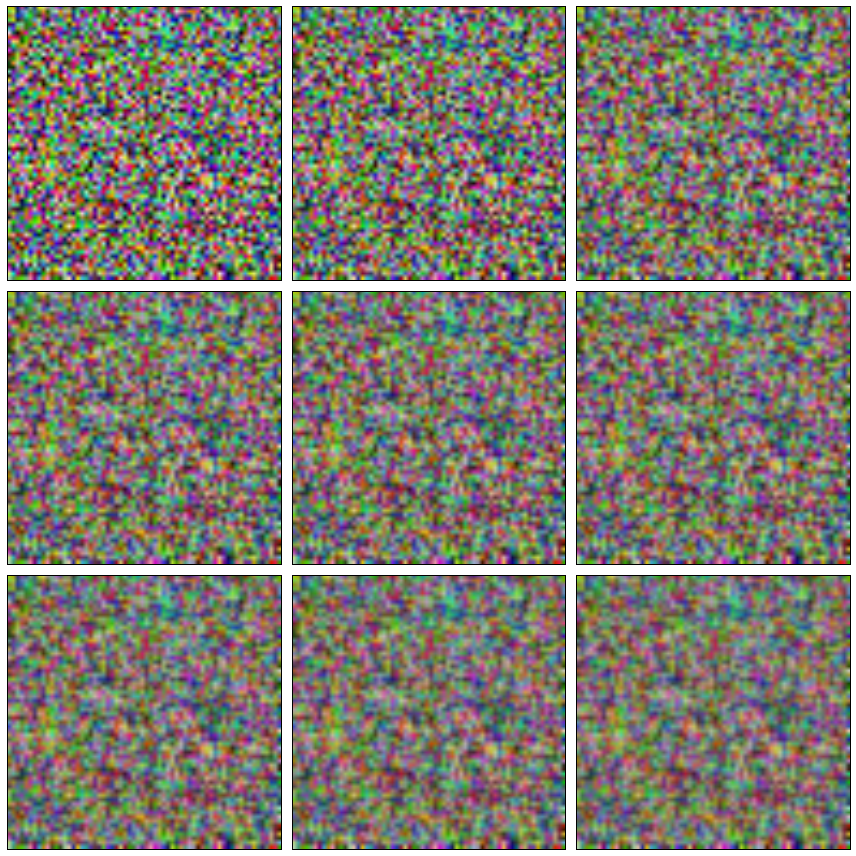

In [114]:
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.gca().xaxis.set_visible(False)    
    plt.gca().yaxis.set_visible(False)    
    plt.imshow(deprocess(xs[i]))
plt.tight_layout()